# Data Processing with `geoPFA`: 3D Example from Newberry Volcano, OR
This tutorial demonstrates how to use the **data processing workflow** in `geoPFA`.  
You’ll learn how to:

1. Load a PFA configuration file (which defines criteria, components, and layers)
2. Read raw geospatial datasets into the working `pfa` dictionary
3. Process and clean these datasets into a consistent grid ready for layer combination and favorability modeling

Subsequent notebooks will build upon this by combining layers, applying weights, and producing final favorability models.

## 1. Imports and Setup

In [1]:
# --- General imports ---
from pathlib import Path
import numpy as np
import geopandas as gpd

# --- geoPFA core classes ---
from geopfa.data_readers import GeospatialDataReaders
from geopfa.geopfa3d.processing import Cleaners, Processing
from geopfa.geopfa3d.plotters import GeospatialDataPlotters  # TODO: change to geoPFA.plotters

# --- Utilities ---
from rex.utilities.utilities import safe_json_load
import json

### Define Directories


In [2]:
# Get the directory where this notebook lives
notebook_dir = Path(__file__).resolve().parent if '__file__' in locals() else Path.cwd()

# Define the main project directory (where 'config/', 'data/', and 'notebooks/' live)
project_dir = notebook_dir.parent

# Define subdirectories
config_dir = project_dir / 'config'
data_dir = project_dir / 'data'

# Confirm structure
print('Notebook directory:', notebook_dir)
print('Config directory:', config_dir)
print('Data directory:', data_dir)

# Quick check before proceeding
for folder in [config_dir, data_dir]:
    if not folder.exists():
        raise FileNotFoundError(f"Expected folder not found: {folder}")

Notebook directory: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/3D/notebooks
Config directory: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/3D/config
Data directory: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/3D/data


## 2. Configuration and Data Input
With the project directories defined, the next step is to **read the configuration file** and **load all raw geospatial data** into memory.

Each PFA project is organized according to a hierarchy of criteria → components → layers, where each **layer** represents a dataset.  
![dir_structure](figs/pfa_processing.png)

The configuration JSON defines:
- Which layers belong to which components, and which components belong to which criteria
- Layer metadata including names, coordinate reference systems (CRS), and column definitions  
- Processing instructions (e.g., interpolation methods, z-measure units if projecting a 3D layer to 2D)

To ensure a smooth workflow:
- The structure of the `/data` directory must exactly match those specified in the JSON (see example below). Folder names must match criteria and component names, and file names must match layer names.   
- Each dataset must have consistent column names and units with its config entry.
- See Configuration Instructions for more 

![dir_structure](figs/directory_structure.png)

### Read configuration file

In [3]:
# Path to configuration file
pfa_path = config_dir / 'newberry_superhot_config.json'

# Load JSON configuration safely (handles comments and malformed JSON)
pfa = safe_json_load(str(pfa_path))

# Quick check
if not pfa_path.exists():
    raise FileNotFoundError(f"Configuration file not found: {pfa_path}")

pfa = safe_json_load(str(pfa_path))
print(f"Loaded PFA configuration from: {pfa_path}")

Loaded PFA configuration from: /Users/ntaverna/Documents/DEEPEN/geoPFA/examples/Newberry/3D/config/newberry_superhot_config.json


### Load data into the `pfa` dictionary

In [4]:
# Define the file types to be read (others will be skipped with a warning)
file_types = ['.csv', '.shp','.tec']

# Gather data according to the config structure
pfa = GeospatialDataReaders.gather_data(data_dir, pfa, file_types)

criteria: geologic
	 component: heat
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: temperature_model_500m
		 reading layer: earthquakes
	 component: reservoir
		 reading layer: lineaments
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: earthquakes
		 reading layer: ring_faults
	 component: insulation
		 reading layer: density_joint_inv
		 reading layer: mt_resistivity_joint_inv
		 reading layer: earthquakes
		 reading layer: temperature_model_500m


### Verify that all layers loaded correctly
This simple diagnostic ensures that each layer entry in the `pfa` dictionary contains a `'data'` key with a valid GeoDataFrame.

In [5]:
missing_data_layers = []

for criteria, crit_data in pfa.get('criteria', {}).items():
    for component, comp_data in crit_data.get('components', {}).items():
        for layer, layer_data in comp_data.get('layers', {}).items():
            if 'data' not in layer_data:
                missing_data_layers.append({
                    'criteria': criteria,
                    'component': component,
                    'layer': layer,
                })

if missing_data_layers:
    print('Layers missing data:')
    for item in missing_data_layers:
        print(f" - {item['criteria']} / {item['component']} / {item['layer']}")
else:
    print('All layers contain data.')

All layers contain data.


## 3. Harmonizing Data

Now that all raw layers are loaded into the `pfa` dictionary, we’ll:
- Define a target coordinate reference system (CRS)
- Constrain grid resolution (`nx`, `ny`, and `nz`)
- Set a consistent vertical reference (z-measurement)
- Import supporting data such as an area outline or a well path to give context
- Derive a shared spatial extent for clipping and gridding
- Preview the input data layers

### Define the Target CRS and Import Contextual Data

In [6]:
# EPSG code for UTM Zone 10N (meters)
target_crs = 26910
target_z_meas = 'm-msl'
# Define grid resolution (number of cells in x, y, z)
nx = 100; ny = 100; nz = 50 # these values are set low to speed up this step in the tutorial. It is recommended to increase the resolutiohn for scientific applications.

# Load the project boundary shapefile
outline_path = data_dir / 'supporting_data' / 'national_monument_boundary' / 'NNVM_bounds.shp'
outline = gpd.read_file(outline_path).to_crs(target_crs)

print(f"Loaded boundary: {outline_path.name}")

Loaded boundary: NNVM_bounds.shp


### Unify CRS and Define Extent
CRS is defined manually using the variable `target_crs` defined above. 
Extent is defined using the defined `extent_layer` above, where the project extent is set to that of the specified `extent_layer`.

In [7]:
# Reproject all layers to the target CRS
pfa = Cleaners.set_crs(pfa, target_crs=target_crs)

# Choose one representative layer to define the spatial extent
extent_layer = (
    pfa['criteria']['geologic']['components']['heat']['layers']['mt_resistivity_joint_inv']['data']
)
extent = Cleaners.get_extent_3d(extent_layer)

# Manually adjust z-extent for this project (meters)
extent[2] = np.float64(-6000)

# Validate the extent
print(f"Extent: {extent}")
if extent[0] >= extent[3] or extent[1] >= extent[4] or extent[2] >= extent[5]:
    raise ValueError('Invalid extent: min values must be less than max values.')

# Define the active criterion (geologic only in this example)
criteria = 'geologic'

Extent: [624790.891073, 4825350.71118, -6000.0, 653145.891073, 4855310.71118, 2379.88418165]


### Extrude Fault Traces to 3D
`geoPFA` has built-in functionality to take 2D fault traces and extend them to the bottom of the model, making them 3D. This is done using the function `Processing.extrude_2d_to_3d` To get the best results, strike and dip should be inputted. If no strike and dip are provided, vertical faults are assumed.


--- Processing reservoir/lineaments ---


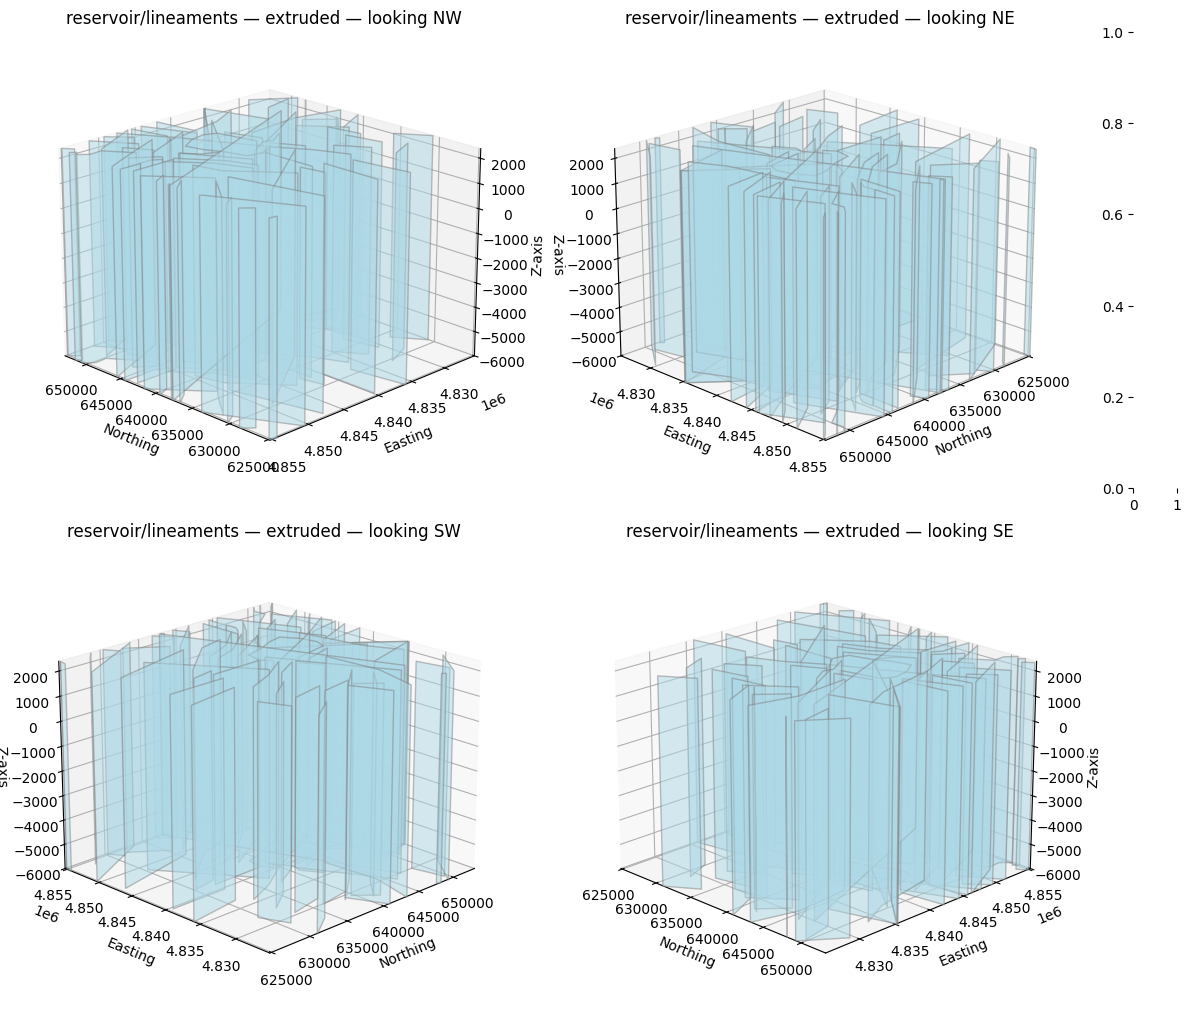

In [8]:
# list of (component, layer, z_min, z_max)
layers = [
    ('reservoir', 'lineaments'),
]

for comp, lyr in layers:
    print(f"\n--- Processing {comp}/{lyr} ---")
    # extrude
    pfa = Processing.extrude_2d_to_3d(
        pfa,
        criteria='geologic',
        component=comp,
        layer=lyr,
        extent=extent,
        target_z_meas=target_z_meas,
        nz=nz
    )

    # plot extruded solids as 3D geometry
    gdf_extr = pfa['criteria']['geologic']['components'][comp]['layers'][lyr]['data']
    GeospatialDataPlotters.geo_plot_3d(
        gdf_extr,
        col='None',
        units='',
        title=f"{comp}/{lyr} — extruded",
        extent=extent
    )

### Standardize Z-Measurements
Often times, datasets reference elevation differently.
To ensure proper 3D alignment, we’ll convert all layers to a common vertical datum.

In [9]:
for criteria, crit_data in pfa['criteria'].items():
    print(criteria)
    for component, comp_data in crit_data['components'].items():
        print(f"\t{component}")
        for layer, layer_data in comp_data['layers'].items():
            print(f"\t\t{layer}")
            gdf = layer_data['data']
            z_meas = layer_data['z_meas']

            if target_z_meas != z_meas:
                print(f"\t\t converting z from {z_meas} → {target_z_meas}")
                print(f"\t\tmin z: {gdf.geometry.z.min():.1f}, max z: {gdf.geometry.z.max():.1f}")

                converted = Cleaners.convert_z_measurements(gdf, z_meas, target_z_meas)
                pfa['criteria'][criteria]['components'][component]['layers'][layer]['data'] = converted

geologic
	heat
		density_joint_inv
		mt_resistivity_joint_inv
		temperature_model_500m
		 converting z from epsg:26910 → m-msl
		min z: -9950.0, max z: 2550.0
		 successful import


/usr/local/anaconda3/envs/geopfa-new/lib/python3.11/site-packages/osgeo/osr.py:424: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


		earthquakes
		 converting z from epsg:26910 → m-msl
		min z: -23400.0, max z: 1991.0
		 successful import
	reservoir
		density_joint_inv
		mt_resistivity_joint_inv
		earthquakes
		 converting z from epsg:26910 → m-msl
		min z: -23400.0, max z: 1991.0
		 successful import
		ring_faults
		 converting z from epsg:26910 → m-msl
		min z: -135.2, max z: 3265.9
		 successful import
		lineaments
	insulation
		density_joint_inv
		mt_resistivity_joint_inv
		earthquakes
		 converting z from epsg:26910 → m-msl
		min z: -23400.0, max z: 1991.0
		 successful import
		temperature_model_500m
		 converting z from epsg:26910 → m-msl
		min z: -9950.0, max z: 2550.0
		 successful import


### Visualize Cleaned Raw Data Layers
`geoPFA` has built-in plotting tools to help visualize data. Some examples are shown below using `GeospatialDataPlotters.geo_plot_3d`.
#### Plot a Single Layer

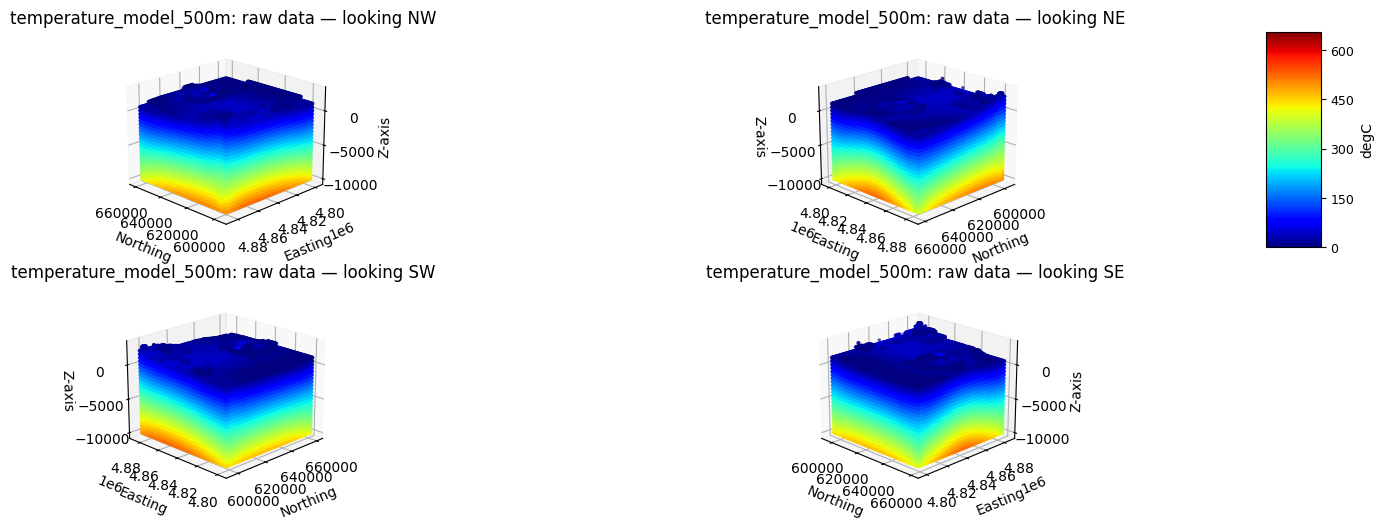

In [10]:
component = 'heat'
layer = 'temperature_model_500m'

gdf = pfa['criteria'][criteria]['components'][component]['layers'][layer]['data']
col = pfa['criteria'][criteria]['components'][component]['layers'][layer]['data_col']
units = pfa['criteria'][criteria]['components'][component]['layers'][layer]['units']
title = f"{layer}: raw data"

GeospatialDataPlotters.geo_plot_3d(gdf, col, units, title, markersize=3, figsize=(15, 5))

#### Plot All Layers (Optional)

Loop through the full hierarchy and visualize every dataset.
This is useful for verifying that CRS, units, and extents align, but can take time for large inputs.

geologic
	heat


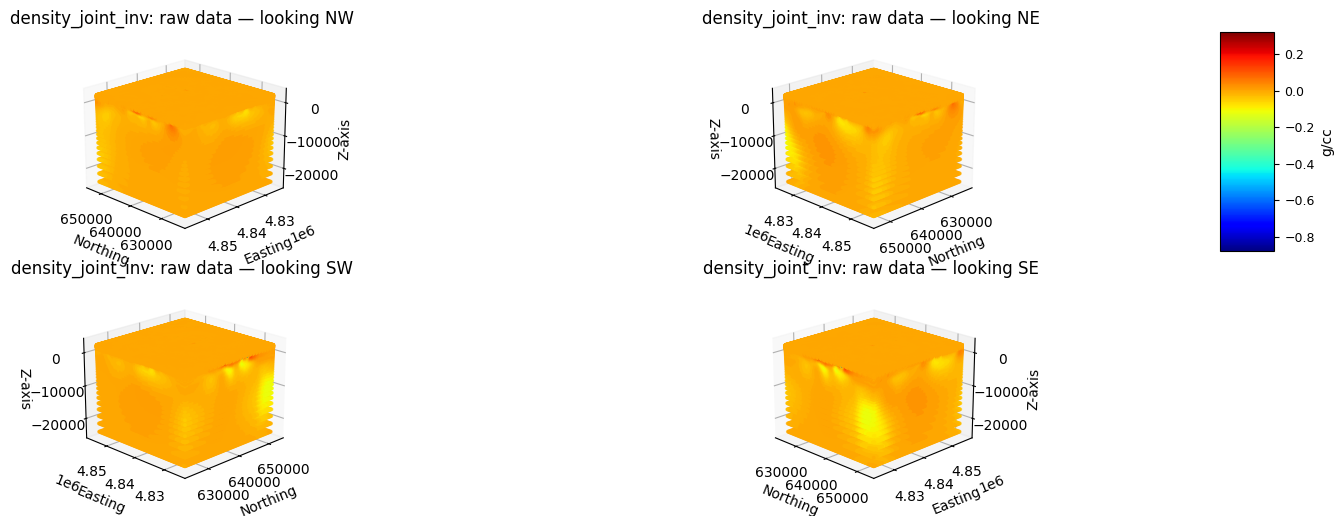

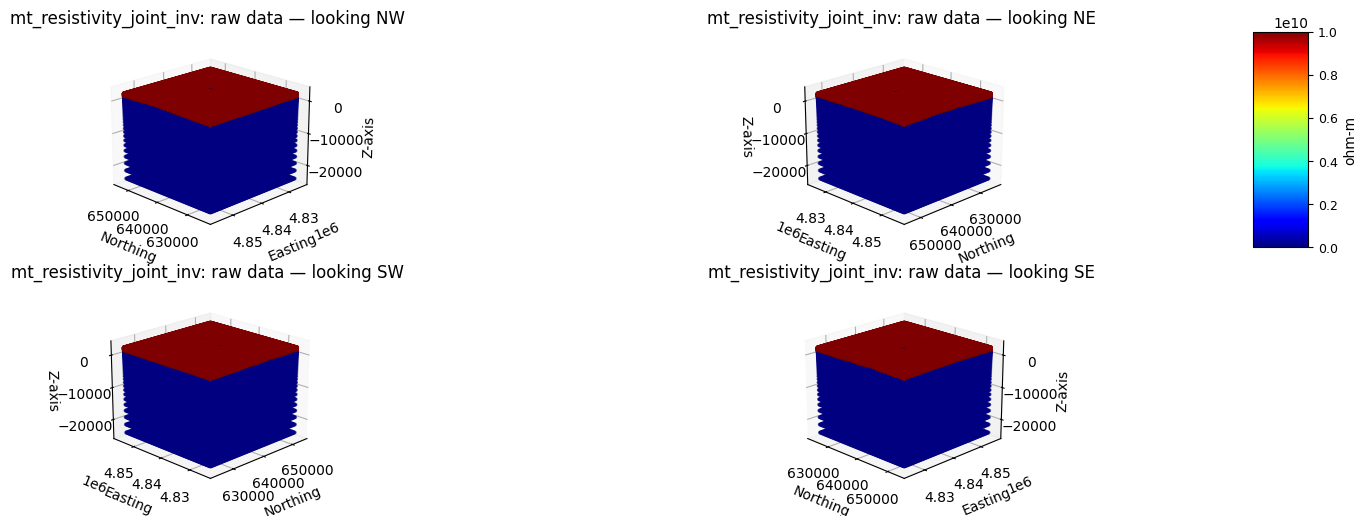

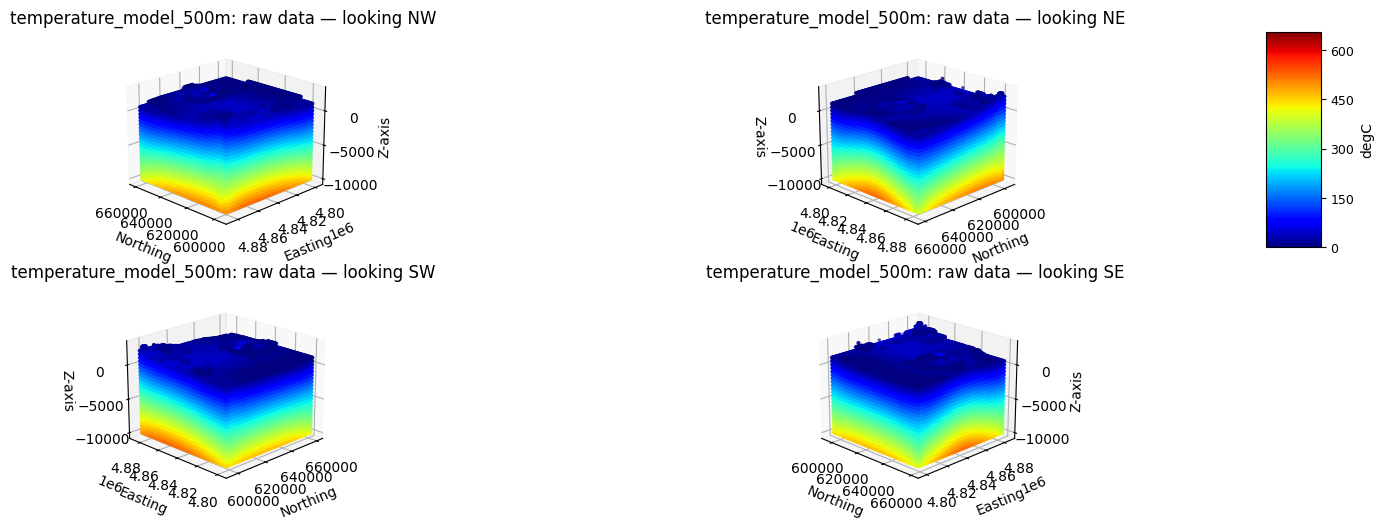

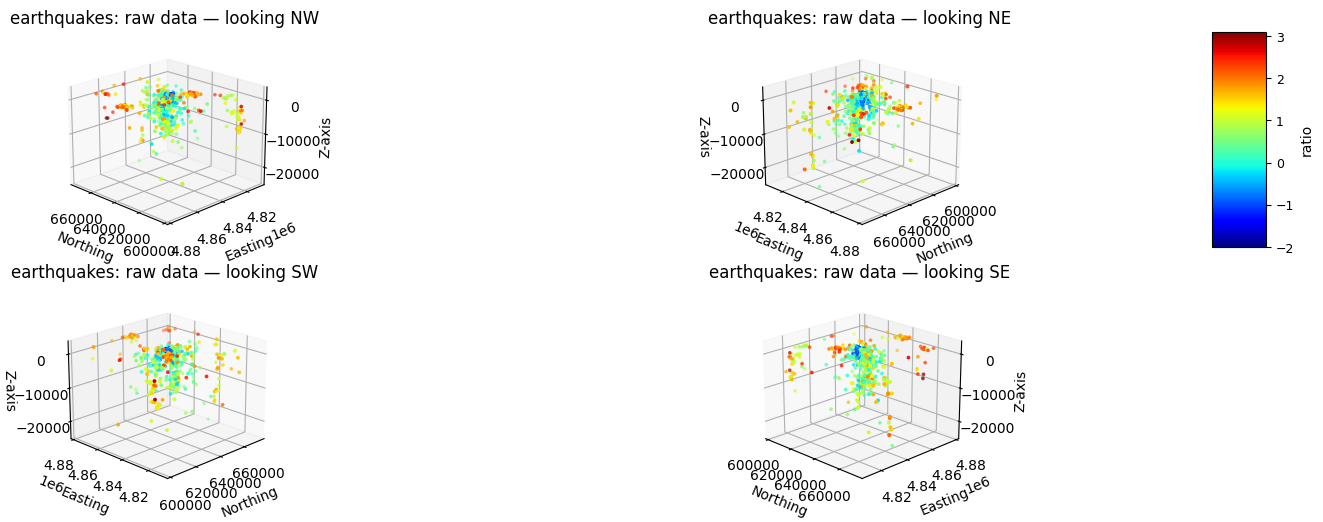

	reservoir
		density_joint_inv plotted already
		mt_resistivity_joint_inv plotted already
		earthquakes plotted already


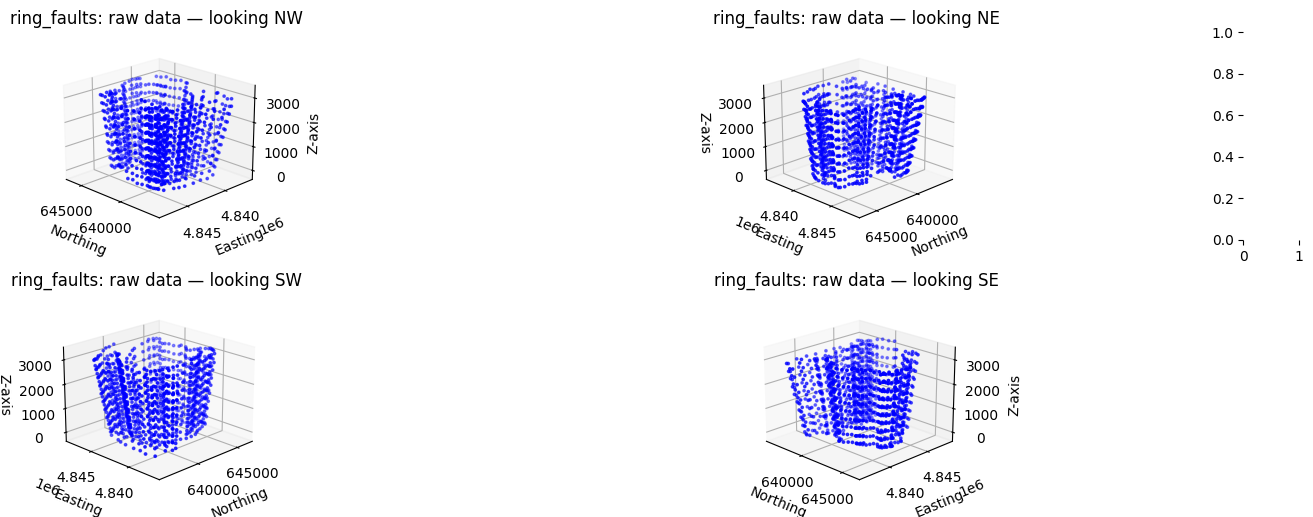

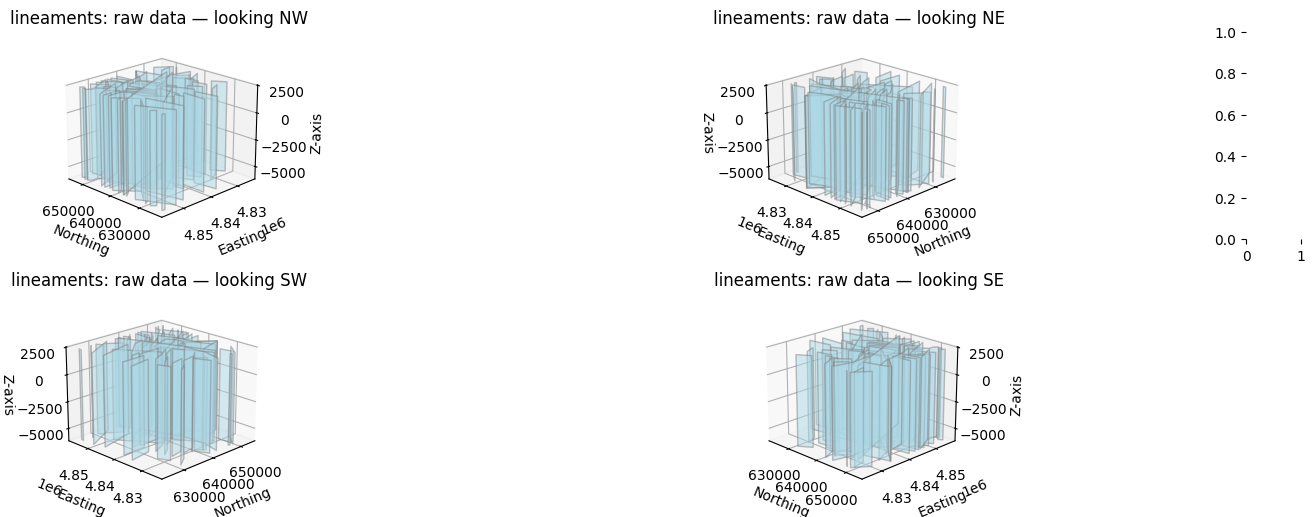

	insulation
		density_joint_inv plotted already
		mt_resistivity_joint_inv plotted already
		earthquakes plotted already
		temperature_model_500m plotted already


In [11]:
for criteria, crit_data in pfa['criteria'].items():
    print(criteria)
    plotted_layers = []
    for component, comp_data in crit_data['components'].items():
        print(f"\t{component}")
        for layer, layer_data in comp_data['layers'].items():
            if layer in plotted_layers:
                print(f"\t\t{layer} plotted already")
                continue

            gdf = layer_data['data']
            col = layer_data.get('data_col', None)
            if layer == 'faults':
                col = None  # faults are geometries only

            units = layer_data['units']
            title = f"{layer}: raw data"

            GeospatialDataPlotters.geo_plot_3d(gdf, col, units, title, markersize=3, figsize=(15, 5))
            plotted_layers.append(layer)

## 4. Data Processing and Preparation
This step transforms raw geospatial inputs into standardized layers on a shared 3D grid for comparison and combination.

Examples:
- *Permeability indicators*: distance to faults, earthquake density  
- *Heat indicators*: resistivity, temperature, low density  
- *Insulation indicators*: shallow resistivity  
- *Insulation indicators*: shallow resistivity, seismic velocity 

Processing ensures all layers:
- Are free from outliers  
- Share the same CRS and spatial extent  
- Are mapped to the same `(nx, ny, nz)` grid  
- Represent continuous 3D evidence produced from the data layer (e.g. distance from faults as opposed to fault location)

---

### How It Works

All `geoPFA` processing functions follow the same pattern:

1. Take the **raw input** stored in  
   `pfa['criteria'][criteria]['components'][component]['layers'][layer]['data']`
2. Process it (e.g., interpolation, point density, distance-to-feature)  
   onto the common 3D grid
3. Write the result to  
   `pfa['criteria'][criteria]['components'][component]['layers'][layer]['model']`


### Filter Outliers
Some datasets contain spurious extreme values.
Use Cleaners.filter_geodataframe() to remove these outliers based on a quantile threshold.

In [12]:
# Filter the upper 10% of values in selected datasets
target_layers = ['mt_resistivity_joint_inv'] # add layers to this list if you;d like to use this function

for layer in target_layers:
    for component in ['heat', 'reservoir']:
        gdf = pfa['criteria'][criteria]['components']['heat']['layers'][layer]['data'].copy()
        col = pfa['criteria'][criteria]['components']['heat']['layers'][layer]['data_col']

        filtered = Cleaners.filter_geodataframe(gdf, col, quantile=0.65)
        pfa['criteria'][criteria]['components'][component]['layers'][layer]['data'] = filtered

print('Outlier filtering complete.')

✅ Outlier filtering complete.


### Log Transform Resistivity
Resistivity values typically span several orders of magnitude; using a logarithmic transform linearizes their distribution.

In [13]:
for comp in ['heat', 'reservoir', 'insulation']:
    gdf = pfa['criteria']['geologic']['components'][comp]['layers']['mt_resistivity_joint_inv']['data'].copy()
    col = pfa['criteria']['geologic']['components'][comp]['layers']['mt_resistivity_joint_inv']['data_col']
    gdf.loc[gdf[col] == 0,col] = 0.00001
    gdf[col] = np.log(gdf[col])
    vals = gdf[col]
    mask = vals.notna() & vals.replace([float('inf'), float('-inf')], float('nan')).notna()
    gdf = gdf[mask]

    pfa['criteria']['geologic']['components'][comp]['layers']['mt_resistivity_joint_inv']['data'] = gdf
    pfa['criteria']['geologic']['components'][comp]['layers']['mt_resistivity_joint_inv']['units'] = 'log(ohm-m)'

## Interpolation
Interpolation is required in the PFA workflow for some datasets to ensure that they are continuous representations of the data within the defined extent.

> **Notes on Interpolation**
>
> Interpolation can take a long time for large datasets and fine 3D grids (30–90+ minutes).
> 
> To avoid the need to re-interpolate repeatedly as minor adjustments are made to the PFA, 'processed' versions of each dataset are saved as intermediate outputs at the bottom of this notebook.
>
> If you skip interpolation:
> - Layers that normally require interpolation will **not** have a `'model'` entry in the `pfa` dictionary.
> - These layers cannot be plotted or combined until you load preprocessed versions (next notebook).

In [14]:
method = 'nearest'

interpolated_layers = {}

for criteria, crit_data in pfa['criteria'].items():
    print(criteria)
    for component, comp_data in crit_data['components'].items():
        print(f"\t{component}")
        for layer, layer_config in comp_data['layers'].items():
            if layer_config.get('processing_method') == 'interpolate':
                if layer in interpolated_layers:
                    print(f"\t\tReusing cached interpolation for {layer}")
                    pfa['criteria'][criteria]['components'][component]['layers'][layer]['model'] = (
                        interpolated_layers[layer]['model'].copy()
                    )
                    pfa['criteria'][criteria]['components'][component]['layers'][layer]['model_data_col'] = (
                        interpolated_layers[layer]['model_data_col']
                    )
                    pfa['criteria'][criteria]['components'][component]['layers'][layer]['model_units'] = (
                        interpolated_layers[layer]['model_units']
                    )
                else:
                    print(f"\t\tInterpolating layer: {layer}")
                    pfa = Processing.fast_interpolate_points_3d(
                        pfa,
                        criteria=criteria,
                        component=component,
                        layer=layer,
                        nx=nx,
                        ny=ny,
                        nz=nz,
                        extent=extent,
                        method=method
                    )
                    interpolated_layers[layer] = (
                        pfa['criteria'][criteria]['components'][component]['layers'][layer].copy()
                    )


geologic
	heat
		Interpolating layer: density_joint_inv
		Grid resolution: 100 x 100 x 50
		Interpolator built in 0.549s
		Interpolation evaluated in 0.176s
		GeoDataFrame built in 1.009s
		Total time: 2.369s
		Interpolating layer: mt_resistivity_joint_inv
		Grid resolution: 100 x 100 x 50
		Interpolator built in 0.565s
		Interpolation evaluated in 0.150s
		GeoDataFrame built in 0.289s
		Total time: 1.638s
		Interpolating layer: temperature_model_500m
		Grid resolution: 100 x 100 x 50
		Interpolator built in 0.226s
		Interpolation evaluated in 0.131s
		GeoDataFrame built in 0.309s
		Total time: 0.957s
	reservoir
		Reusing cached interpolation for density_joint_inv
		Reusing cached interpolation for mt_resistivity_joint_inv
	insulation
		Reusing cached interpolation for density_joint_inv
		Reusing cached interpolation for mt_resistivity_joint_inv
		Reusing cached interpolation for temperature_model_500m


### Point Density to be Used as a Favorability Proxy

For some layers, the spatial density of points (e.g., earthquake occurrences) is an indicator of permeability or fracturing. `geoPFA` has two options to do this in 3D, including:
 - `Processing.point_density_3d_projected`: Computes 3D density projected onto user-defined grids (ofter coarser than the project grid), ,and then project those onto the project grid to allow PFA computations that rely on harmonized grids.
 - `Processing.weighted_distance_from_points_3d`: Compute a weighted influence field from points over the 3D project grid, using distance to control 'influence,' optionallly weighted by an attribute of the user's choice (e.g., earthquake magnitude).

In this example, we use `Processing.weighted_distance_from_points_3d` because it produces smoother results and alllows us to incorporate earthquake magnitude.

> *Tuning Tip:* Larger `alpha` values spread each equarthquake’s influence farther; smaller values make it more localized. In other words, a larger value for `alpha` might be preferably when wworking with relatively sparse earthquakes.

In [15]:
# Compute 3D density for earthquake points across components
for comp in ['heat', 'reservoir', 'insulation']:
    pfa = Processing.weighted_distance_from_points_3d(
        pfa,
        criteria='geologic',
        component=comp,
        layer='earthquakes',
        extent=extent,
        nx=nx,
        ny=ny,
        nz=nz,
        alpha=5000 # a larger value for alpha is better when earthquake data is realtively sparse (true for Newberry)
    )

# Filter extreme densities
for comp in ['heat', 'reservoir', 'insulation']:
    gdf = pfa['criteria']['geologic']['components'][comp]['layers']['earthquakes']['model'].copy()
    col = pfa['criteria']['geologic']['components'][comp]['layers']['earthquakes']['model_data_col']
    filtered = Cleaners.filter_geodataframe(gdf, col, quantile=0.99)
    pfa['criteria']['geologic']['components'][comp]['layers']['earthquakes']['model'] = filtered


#### Visualize Earthquake Density
Filter to scores greater than the 0.75 percentile for easier visualization.

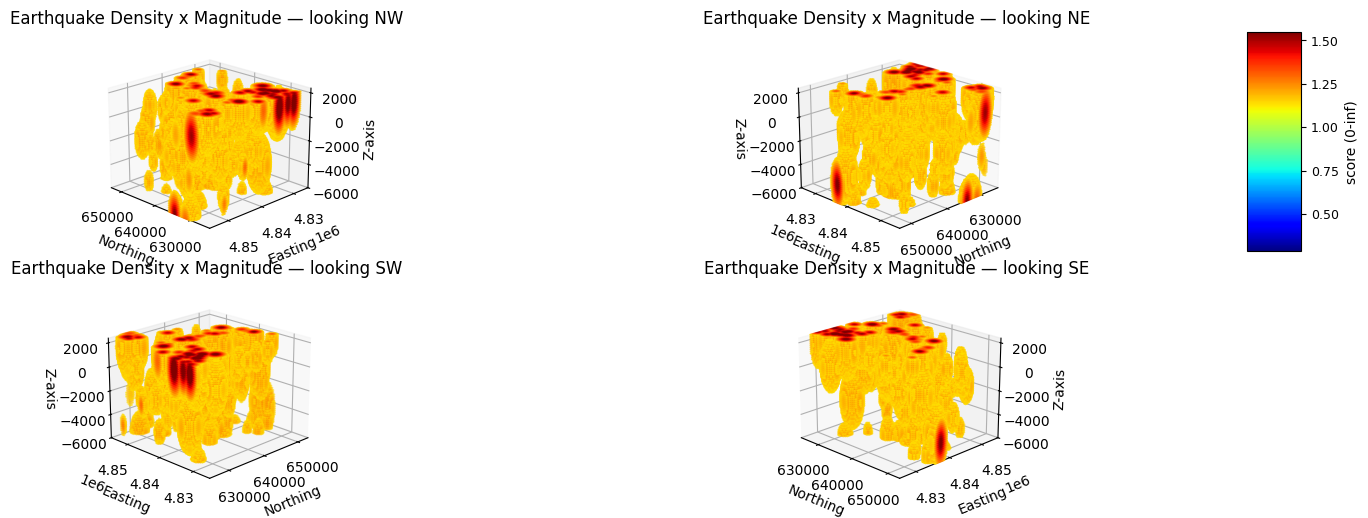

In [16]:
gdf = pfa['criteria']['geologic']['components']['reservoir']['layers']['earthquakes']['model']
col = pfa['criteria']['geologic']['components']['reservoir']['layers']['earthquakes']['model_data_col']
units = pfa['criteria']['geologic']['components']['reservoir']['layers']['earthquakes']['model_units']
thresh = gdf[col].quantile(0.75)

GeospatialDataPlotters.geo_plot_3d(
    gdf, 
    col, 
    units, 
    'Earthquake Density x Magnitude', 
    extent=extent, 
    markersize=0.5, 
    figsize=(15, 5),
    filter_threshold = thresh
)

### Distance to Faults
Faults often act as preferential pathways for fluid flow, making them key indicators for the *reservoir* component. To incorporate fautls into the PFA, we first convert fault points into surfaces, then compute 3D distance from those solids.

In [17]:
# Generate fault surfaces from point clusters
criteria='geologic'
component='reservoir'
layer='ring_faults'

gdf_points = pfa['criteria'][criteria]['components'][component]['layers'][layer]['data']
fault_number_col = 'Fault_Number'  # Unique Identifier column in original data file that maps each point to a specific fault
pfa['criteria'][criteria]['components'][component]['layers'][layer]['data'] = (
    Processing.create_fault_surfaces_from_points(gdf_points, fault_number_col)
)

# Calculate 3D distance to fault surfaces
pfa = Processing.distance_from_3d_solids(
    pfa,
    criteria=criteria,
    component=component,
    layer=layer,
    extent=extent,
    nx=nx,
    ny=ny,
    nz=nz,
)

layer='lineaments'
# Calculate 3D distance to fault surfaces
pfa = Processing.distance_from_3d_solids(
    pfa,
    criteria=criteria,
    component=component,
    layer=layer,
    extent=extent,
    nx=nx,
    ny=ny,
    nz=nz,
)

#### Visualize Fault Distance
Slice plot in the x direction to better observe the distance function.

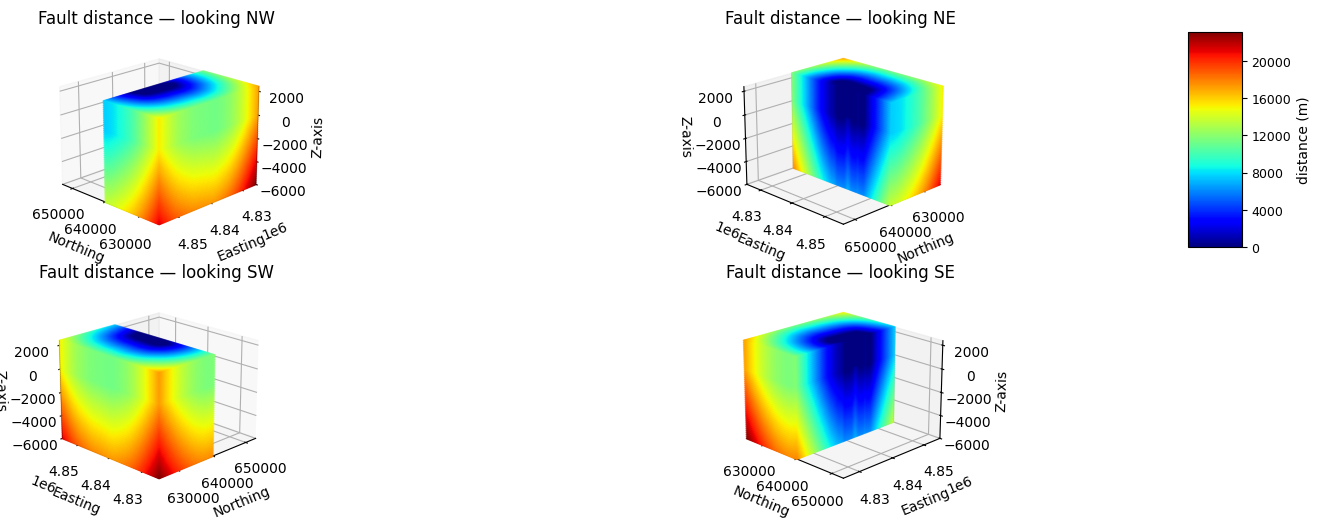

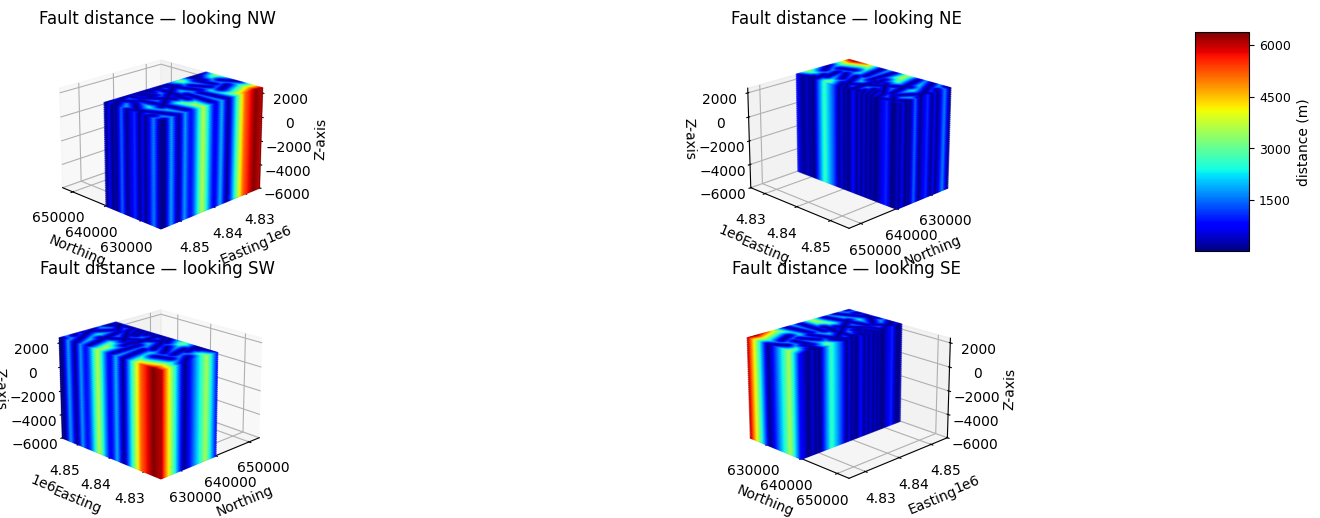

In [18]:
gdf = pfa['criteria']['geologic']['components']['reservoir']['layers']['ring_faults']['model']
col = pfa['criteria']['geologic']['components']['reservoir']['layers']['ring_faults']['model_data_col']
units = pfa['criteria']['geologic']['components']['reservoir']['layers']['ring_faults']['model_units']

GeospatialDataPlotters.geo_plot_3d(gdf, col, 'distance ('+units+')', 'Fault distance', extent=extent,
                                   markersize=0.5, figsize=(15,5), x_slice=640000)

gdf = pfa['criteria']['geologic']['components']['reservoir']['layers']['lineaments']['model']
GeospatialDataPlotters.geo_plot_3d(gdf, col, 'distance ('+units+')', 'Fault distance', extent=extent,
                                   markersize=0.5, figsize=(15,5), x_slice=640000)

### Plot All Processed Layers

In [19]:
# Some layers may not have 'model' entries if interpolation or a processing step was skipped.
# These layers will be skipped automatically with a note to the user.

for criteria, crit_data in pfa['criteria'].items():
    print(criteria)
    plotted_layers = []

    for component, comp_data in crit_data['components'].items():
        print(f"\t{component}")

        for layer, layer_data in comp_data['layers'].items():
            print(layer)
            if layer in plotted_layers:
                continue

            # Skip if no processed model exists
            if 'model' not in layer_data or layer_data['model'] is None:
                print(f"\t\tSkipping {layer}: no processed 'model' found (likely not interpolated).")
                continue

            gdf = layer_data['model']
            col = layer_data.get('model_data_col')
            units = layer_data.get('model_units', 'None')
            title = f"{layer}: processed model"
            thresh = gdf[col].quantile(0.75)
            print(col)

            # Plot in 3D
            GeospatialDataPlotters.geo_plot_3d(
                gdf, col, units, title, extent=extent, filter_thresholdmarkersize=0.5, figsize=(15, 5)
            )

            plotted_layers.append(layer)

print('\nFinished plotting all available processed layers.')


SyntaxError: invalid syntax. Perhaps you forgot a comma? (285641084.py, line 18)

## Save Processed Layers

Because interpolation and 3D processing are computationally costly, it’s good practice to save processed data to disk before proceeding. This allows the user to make minor tweaks to the PFA, such as adjusting weights, without reprocessing all data layers.

In [ ]:
for criteria, crit_data in pfa['criteria'].items():
    print(criteria)
    for component, comp_data in crit_data['components'].items():
        print(f"\t{component}")
        for layer, layer_data in comp_data['layers'].items():
            gdf = layer_data['model']
            col = layer_data['model_data_col']
            units = layer_data['model_units']

            out_fp = data_dir / criteria / component / f"{layer}_processed.csv"
            gdf.to_csv(out_fp, index=False)
            print(f"\t\tSaved: {out_fp}")

### Save a “Clean” PFA Config (no GeoDataFrames)
Similarly, saving a 'clean' processed PFA config allows the user to avoid repeating the processing step when making minor adjustments to the PFA. This processed config serves as the config file for the next step. 

In [ ]:
def drop_geodataframes(data: dict) -> dict:
    '''Recursively remove GeoDataFrame objects before saving.'''
    clean = {}
    for key, val in data.items():
        if isinstance(val, gpd.GeoDataFrame):
            continue
        elif isinstance(val, dict):
            clean[key] = drop_geodataframes(val)
        else:
            clean[key] = val
    return clean

pfa_nodf = drop_geodataframes(pfa)
out_json = config_dir / 'newberry_superhot_processed_config.json'
with open(out_json, 'w') as f:
    json.dump(pfa_nodf, f, indent=4)
    print("Processed PFA configuration saved to: {out_json}")

---

## Next Steps: Layer Combination and Favorability Modeling

This concludes **Notebook 1 – Data Processing with `geoPFA`**.

In this notebook, we:
- Loaded, cleaned, and standardized all input datasets  
- Processed each layer (filtering, interpolation, density, distance, transformations)  
- Saved the resulting **processed layers** to disk

You’re now ready to combine these layers into component and criteria favorability models.

If you skip running this notebook, don’t worry — the **supplementary example data** includes all intermediate processed files.  
You can start directly with **Notebook 2 – Layer Combination and Favorability Modeling**, which loads those preprocessed layers automatically.

---
